# Pipeline processing using Dask

This notebook demonstrates the continuum imaging and ICAL pipelines.

In [1]:
%matplotlib inline

import os
import sys
sys.path.append(os.path.join('..','..'))

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

from dask import delayed
import dask
import dask.distributed

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy


import pprint

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from arl.calibration.solvers import solve_gaintable
from arl.calibration.operations import apply_gaintable
from arl.calibration.calibration_control import create_calibration_controls
from arl.data.data_models import Image
from arl.data.polarisation import PolarisationFrame
from arl.data.parameters import get_parameter
from arl.visibility.base import create_blockvisibility
from arl.skycomponent.operations import create_skycomponent
from arl.image.deconvolution import deconvolve_cube
from arl.image.operations import show_image, export_image_to_fits, qa_image, copy_image, create_empty_image_like
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration, create_low_test_beam
from arl.imaging import predict_2d, create_image_from_visibility, advise_wide_field

from arl.graphs.dask_init import get_dask_Client
from arl.graphs.delayed import create_invert_graph, create_predict_graph, create_deconvolve_graph, \
    create_residual_graph, compute_list
from arl.imaging.imaging_context import imaging_context
from arl.graphs.generic_graphs import create_generic_image_graph
from arl.util.delayed_support import create_simulate_vis_graph, \
    create_low_test_image_from_gleam, create_corrupt_vis_graph
from arl.pipelines.delayed import create_continuum_imaging_pipeline_graph, \
    create_ical_pipeline_graph    

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
pp = pprint.PrettyPrinter()
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'


Make a Dask client to manage the processing. Diagnostics are available at the URL given. Try the Status entry.

In [3]:
c=get_dask_Client()

Using selector: KqueueSelector
Using selector: KqueueSelector
Creating LocalCluster and Dask Client
Using selector: KqueueSelector
Using selector: KqueueSelector
<Client: scheduler='tcp://127.0.0.1:52608' processes=8 cores=8>
Diagnostic pages available on port http://127.0.0.1:8787


We create a graph to make the visibility. The parameter rmax determines the distance of the furthest antenna/stations used. All over parameters are determined from this number.

In [4]:
nfreqwin=7
ntimes=11
rmax=300.0
frequency=numpy.linspace(0.8e8,1.2e8,nfreqwin)
channel_bandwidth=numpy.array(nfreqwin*[frequency[1]-frequency[0]])
times = numpy.linspace(-numpy.pi/3.0, numpy.pi/3.0, ntimes)
phasecentre=SkyCoord(ra=+30.0 * u.deg, dec=-60.0 * u.deg, frame='icrs', equinox='J2000')

vis_graph_list=create_simulate_vis_graph('LOWBD2',
                                         frequency=frequency, 
                                         channel_bandwidth=channel_bandwidth,
                                         times=times,
                                         phasecentre=phasecentre,
                                         order='frequency',
                                        rmax=rmax)
print('%d elements in vis_graph_list' % len(vis_graph_list))
vis_graph_list = compute_list(c, vis_graph_list)

create_configuration_from_file: Maximum radius 300.0 m includes 94 antennas/stations
create_simulate_vis_graph: Simulating distribution in frequency
7 elements in vis_graph_list


In [5]:
wprojection_planes=1
advice_low=advise_wide_field(vis_graph_list[0], guard_band_image=8.0, delA=0.02,
                             wprojection_planes=wprojection_planes)

advice_high=advise_wide_field(vis_graph_list[-1], guard_band_image=8.0, delA=0.02,
                              wprojection_planes=wprojection_planes)

vis_slices = advice_low['vis_slices']
npixel=advice_high['npixels2']
cellsize=min(advice_low['cellsize'], advice_high['cellsize'])
nfacets=4

convert_visibility: Original 11 rows, 0.004 GB, converted 48081 rows, 0.005 GB
advise_wide_field: Maximum wavelength 3.747 (meters)
advise_wide_field: Minimum wavelength 3.747 (meters)
advise_wide_field: Maximum baseline 152.4 (wavelengths)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Primary beam 0.107069 (rad) 6.135 (deg)
advise_wide_field: Image field of view 0.856550 (rad) 49.077 (deg)
advise_wide_field: Synthesized beam 0.006560 (rad) 0.376 (deg)
advise_wide_field: Cellsize 0.002187 (rad) 0.125 (deg)
advice_wide_field: Npixels per side = 392
advice_wide_field: Npixels (power of 2, 3) per side = 512
advice_wide_field: W sampling for full image = 0.1 (wavelengths)
advice_wide_field: W sampling for primary beam = 5.6 (wavelengths)
advice_wide_field: Time sampling for full image = 15.7 (s)
advice_wide_field: Time sampling for primary beam = 1002.0 (s)
advice_wide_field: Frequency sampling for full image = 14495.9 (Hz)
advice_wide_field: Frequency sampli

Now make a graph to fill with a model drawn from GLEAM 

In [6]:
gleam_model_graph = [delayed(create_low_test_image_from_gleam)(npixel=npixel,
                                                               frequency=[frequency[f]],
                                                               channel_bandwidth=[channel_bandwidth[f]],
                                                               cellsize=cellsize,
                                                               phasecentre=phasecentre,
                                                               polarisation_frame=PolarisationFrame("stokesI"),
                                                               flux_limit=1.0,
                                                               applybeam=True)
                     for f, freq in enumerate(frequency)]
from arl.graphs.delayed import compute_list
gleam_model_graph = compute_list(c, gleam_model_graph)
future_gleam_model_graph = c.scatter(gleam_model_graph)

In [7]:
future_vis_graph = c.scatter(vis_graph_list)
predicted_vis_graph_list = create_predict_graph(future_vis_graph, future_gleam_model_graph,  
                                                context='wstack', vis_slices=vis_slices)
predicted_vis_graph_list = compute_list(c, predicted_vis_graph_list)
corrupted_vis_graph_list = create_corrupt_vis_graph(predicted_vis_graph_list, phase_error=1.0)
corrupted_vis_graph_list = compute_list(c, corrupted_vis_graph_list)

Get the LSM. This is currently blank.

In [8]:
model_graph = [delayed(create_image_from_visibility)(vis_graph_list[f],
                                                     npixel=npixel,
                                                     frequency=[frequency[f]],
                                                     channel_bandwidth=[channel_bandwidth[f]],
                                                     cellsize=cellsize,
                                                     phasecentre=phasecentre,
                                                     polarisation_frame=PolarisationFrame("stokesI"))
               for f, freq in enumerate(frequency)]

Create a graph to make the dirty image 

/Users/timcornwell/anaconda/envs/arlenv/lib/python3.6/site-packages/distributed/worker.py:741: UserWarning: Large object of size 2.10 MB detected in task graph: 
  ([<arl.data.data_models.Image object at 0x112cc2a2 ... .04585361]])],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


Image:
	Shape: (1, 1, 512, 512)
	WCS: WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'STOKES'  'FREQ'  
CRVAL : 30.0  -60.0  1.0  80000000.0  
CRPIX : 257.0  257.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.083529771086581  0.083529771086581  1.0  6666666.6666667  
NAXIS : 0  0
	Polarisation frame: stokesI

findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/timcornwell/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


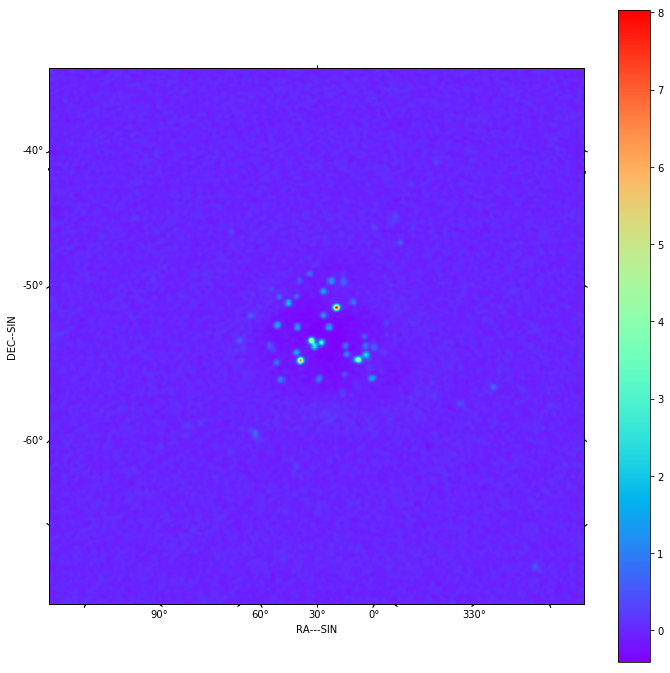

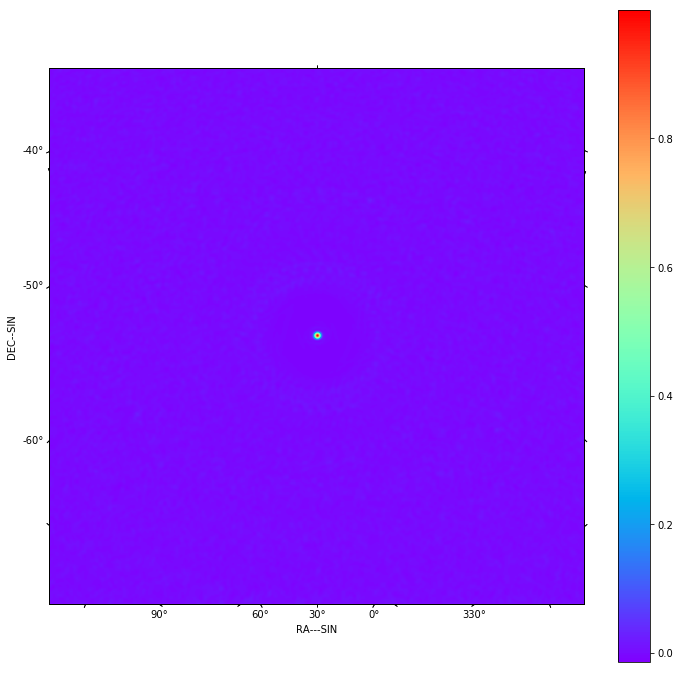

In [9]:
future_predicted_vis_graph_list=c.scatter(predicted_vis_graph_list)
dirty_graph = create_invert_graph(future_predicted_vis_graph_list, model_graph, 
                                  context='wstack',
                                  vis_slices=vis_slices, dopsf=False)
psf_graph = create_invert_graph(future_predicted_vis_graph_list, model_graph, 
                                context='wstack',
                                vis_slices=vis_slices, dopsf=True)
dirty_graph = c.compute(dirty_graph, sync=True)
psf_graph = c.compute(psf_graph, sync=True)
result = c.compute(dirty_graph, sync=True)
dirty = result[0][0]
print(dirty)
show_image(dirty)
plt.show()

result = c.compute(psf_graph, sync=True)
psf = result[0][0]
show_image(psf)
plt.show()

In [13]:
print(dirty_graph)

Image:
	Shape: (1, 1, 512, 512)
	WCS: WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'STOKES'  'FREQ'  
CRVAL : 30.0  -60.0  1.0  80000000.0  
CRPIX : 257.0  257.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.083529771086581  0.083529771086581  1.0  6666666.6666667  
NAXIS : 0  0
	Polarisation frame: stokesI



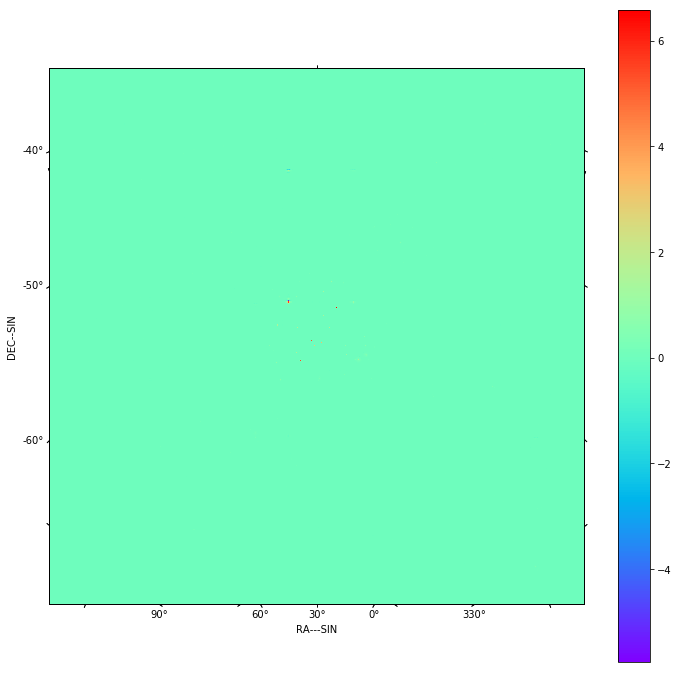

In [10]:
deconvolve_graph = \
    create_deconvolve_graph(dirty_graph, psf_graph, model_graph=model_graph, 
                            deconvolve_facets=8, deconvolve_overlap=32, scales=[0, 3, 10],
                            algorithm='mmclean', niter=1000, 
                            fractional_threshold=0.1,
                            threshold=0.1, ain=0.1)
    
deconvolve_graph.visualize('%s/imaging-pipelines-deconvolve-facet-graph.svg' %(results_dir))

deconvolved = c.compute(deconvolve_graph, sync=True)
show_image(deconvolved[0])
plt.show()

In [11]:
continuum_imaging_graph = \
    create_continuum_imaging_pipeline_graph(predicted_vis_graph_list, 
                                            model_graph=model_graph, 
                                            context='wstack', vis_slices=vis_slices, 
                                            scales=[0, 3, 10], algorithm='mmclean', 
                                            nmoment=3, niter=1000, 
                                            fractional_threshold=0.1,
                                            threshold=0.1, nmajor=5, gain=0.1,
                                            deconvolve_facets = 4, deconvolve_overlap=16)
    
#continuum_imaging_graph.visualize('%s/imaging-pipelines-continuum_imaging-graph.svg' %(results_dir))

In [ ]:
future=c.compute(continuum_imaging_graph)
deconvolved = future.result()[0][0]
residual = future.result()[1][0]
restored = future.result()[2][0]

f=show_image(deconvolved, title='Clean image - no selfcal')
print(qa_image(deconvolved, context='Clean image - no selfcal'))

plt.show()

f=show_image(restored, title='Restored clean image - no selfcal')
print(qa_image(restored, context='Restored clean image - no selfcal'))
plt.show()
export_image_to_fits(restored, '%s/imaging-dask_continuum_imaging_restored.fits' 
                     %(results_dir))

f=show_image(residual[0], title='Residual clean image - no selfcal')
print(qa_image(residual[0], context='Residual clean image - no selfcal'))
plt.show()
export_image_to_fits(residual[0], '%s/imaging-dask_continuum_imaging_residual.fits' 
                     %(results_dir))

In [ ]:
controls = create_calibration_controls()
        
controls['T']['first_selfcal'] = 2
controls['G']['first_selfcal'] = 3
controls['B']['first_selfcal'] = 4

controls['T']['timescale'] = 'auto'
controls['G']['timescale'] = 'auto'
controls['B']['timescale'] = 1e5

pp.pprint(controls)

In [ ]:
ical_graph = create_ical_pipeline_graph(corrupted_vis_graph_list, 
                                        model_graph=model_graph,  
                                        vis_slices=vis_slices,
                                        context='wstack',
                                        timeslice='auto',
                                        deconvolve_facets = 4, deconvolve_overlap=16,
                                        algorithm='hogbom', niter=1000, 
                                        fractional_threshold=0.1,
                                        threshold=0.1, nmajor=5, 
                                        gain=0.1, controls=controls,
                                        global_solution=False)

In [ ]:
future=c.compute(ical_graph)
deconvolved = future.result()[0][0]
residual = future.result()[1][0]
restored = future.result()[2][0]


f=show_image(deconvolved, title='Clean image')
print(qa_image(deconvolved, context='Clean image'))
plt.show()

f=show_image(restored, title='Restored clean image')
print(qa_image(restored, context='Restored clean image'))
plt.show()
export_image_to_fits(restored, '%s/imaging-dask_ical_restored.fits' 
                     %(results_dir))



f=show_image(residual[0], title='Residual clean image')
print(qa_image(residual[0], context='Residual clean image'))
plt.show()
export_image_to_fits(residual[0], '%s/imaging-dask_ical_residual.fits' 
                     %(results_dir))

In [ ]:
c.shutdown()